In [1]:
from typing import List

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
%matplotlib inline

In [202]:
NUM_EPISODES = 300000
START_STATE = 500
ALPHA_AGGR = 2e-5
ALPHA_LINEAR = 2e-5
GAMMA = 1.

<h1> Implementation of 1000 state random walk with equiprobable jump of 100 states on both sides and its solution using state aggregation along with MC returns and linear function approximation along with MC/TD returns <h1>

In [203]:
q_aggr = np.zeros(10)
all_states = []
mse_mc = []
mse_td = []
weights_td = np.array([0.,0,])
weights_mc = np.array([0.,0,])
for i in range(NUM_EPISODES):
    current_state = START_STATE
    visited_states = []
    ret = 0
    while True:
        visited_states.append(current_state)
        all_states.append(current_state)
        right = current_state + 100
        left = current_state - 100
        if np.random.rand() > 0.5:
            next_state = np.random.randint(current_state+1,right+1)
            if next_state > 1000:
                ret = 1
        else:
            next_state = np.random.randint(left,current_state)
            if next_state < 1:
                ret = -1
        if ret == 0:
            target = 0 + GAMMA* weights_td@np.asarray([next_state/1000.,1])
        else:
            target = ret
        estimate_td = weights_td@np.asarray([current_state/1000.,1])
        weights_td = weights_td + ALPHA_LINEAR*(10**2)* (target - estimate_td) * np.asarray([current_state/1000.,1])
        mse_td.append((target - estimate_td)**2)
        if ret != 0:
            break
        current_state = next_state
    for state in visited_states:
        idx = (state - 1) // 100
        q_aggr[idx] = q_aggr[idx] + ALPHA_AGGR * (ret - q_aggr[idx])
        estimate_mc = weights_mc@np.asarray([state/1000.,1])
        weights_mc = weights_mc + ALPHA_LINEAR* (ret - estimate_mc) * np.asarray([state/1000.,1])
        mse_mc.append((ret - estimate_mc)**2)


<h1> Plot the value function and state distribution for both state aggregation (MC only) and linear function approximation (MC/TD-0) </h1>

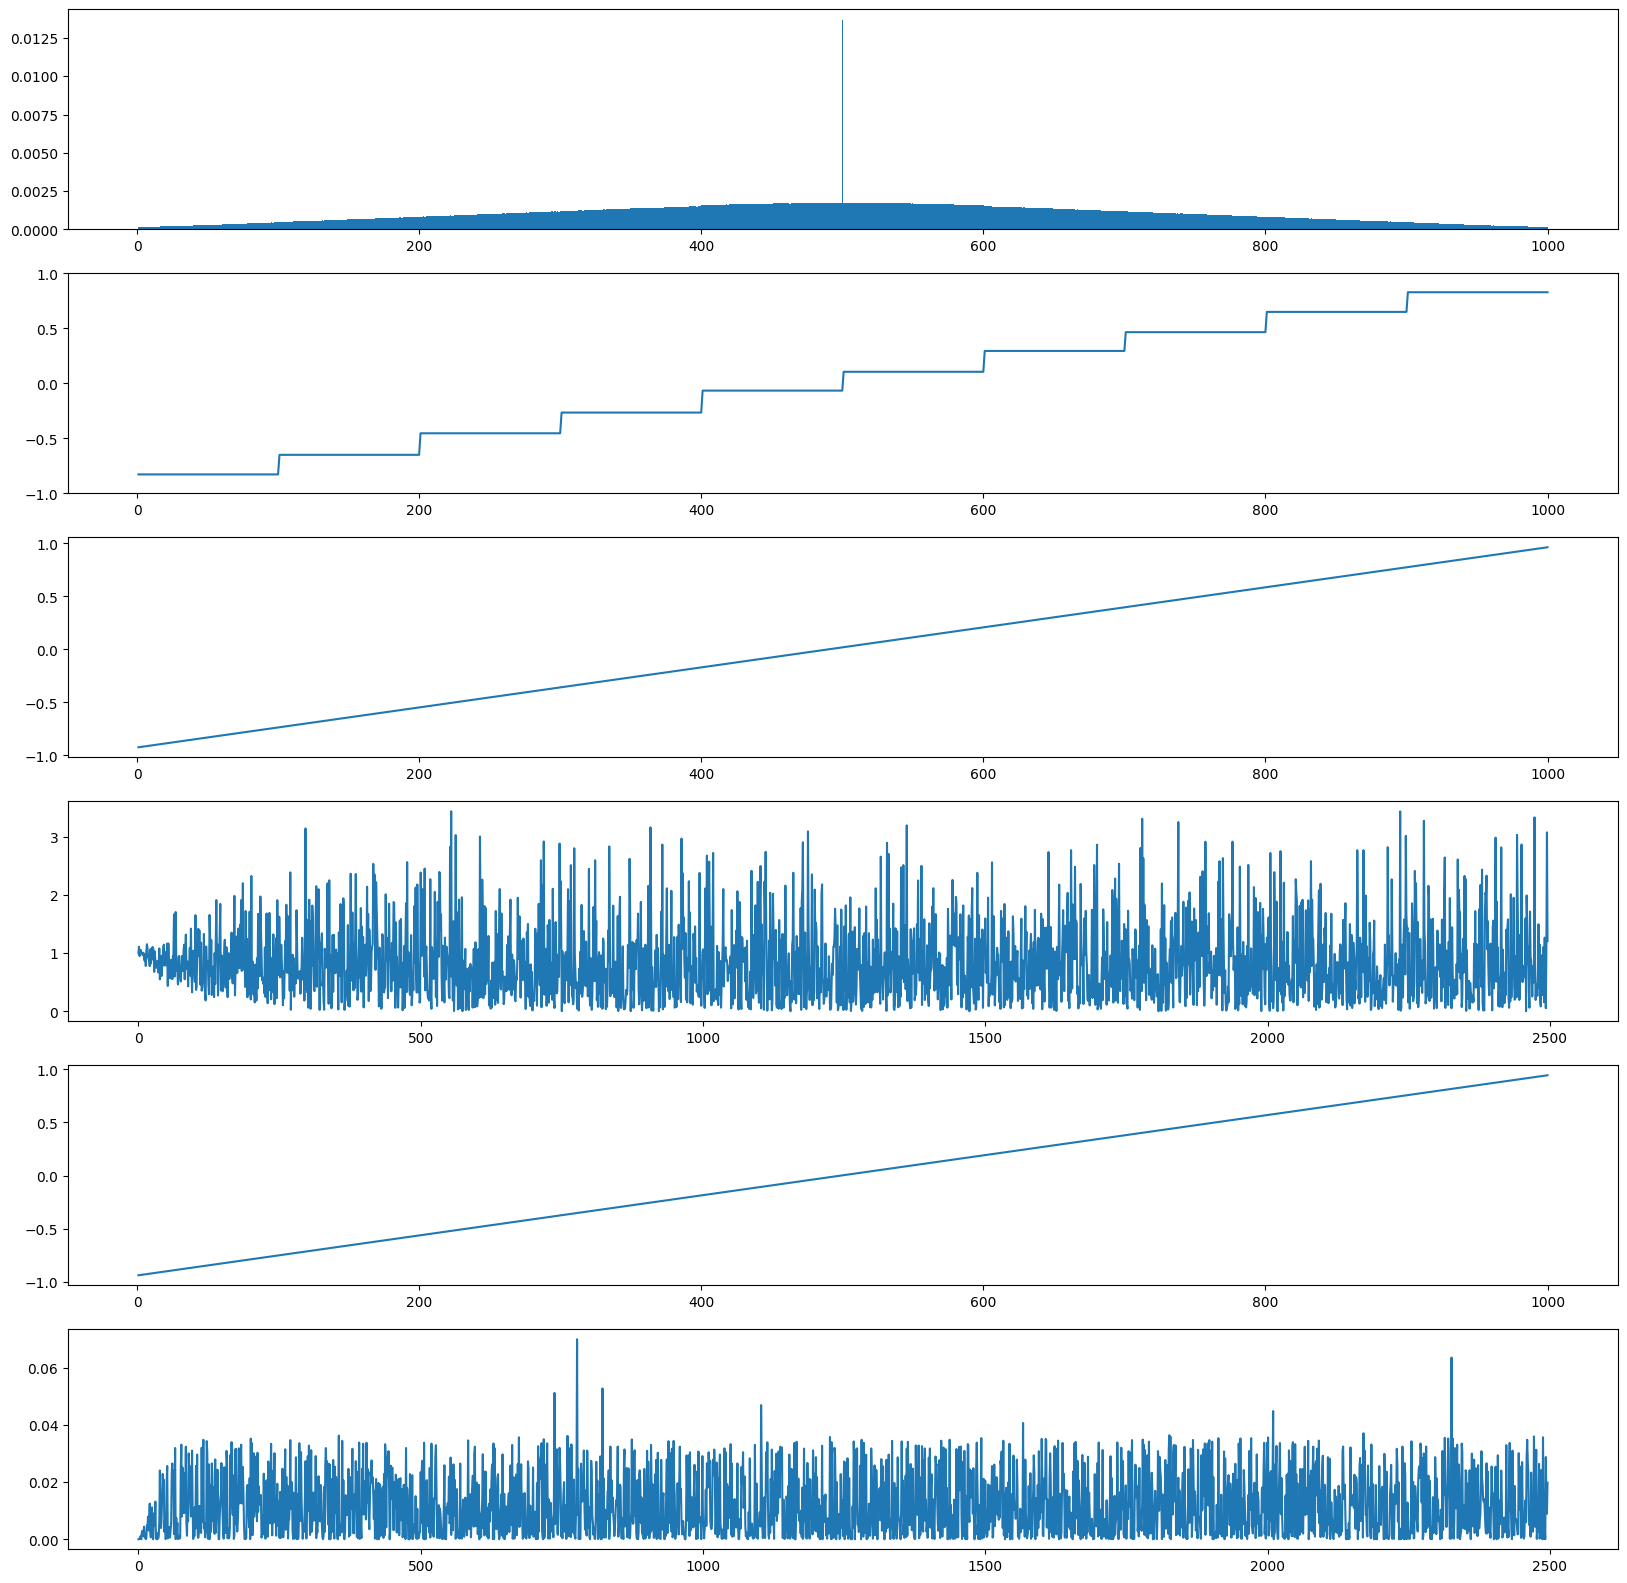

In [204]:
fig:Figure = plt.figure(figsize=(20,20))
ax:List[Axes] = fig.subplots(6,1)
x_axis = np.arange(1,1001)
q_rep = [ q_val for q_val in q_aggr for _ in range(100)]
ax[0].hist(all_states,bins=1000,density=True)
ax[1].set_ylim(-1,1)
ax[1].plot(x_axis,q_rep)
y_axis = [ weights_mc@np.asarray([x/1000.,1]) for x in x_axis]
ax[2].plot(x_axis,y_axis);
ax[3].plot(mse_mc[0:-1:10000]);
y_axis = [ weights_td@np.asarray([x/1000.,1]) for x in x_axis]
ax[4].plot(x_axis,y_axis);
ax[5].plot(mse_td[0:-1:10000]);

<h1> Random walk for Emphasis TD </h1>

In [2]:
class RandomWalk:
    def __init__(self):
        self.s = 0
    def step(self):
        self.s+=1
        if self.s ==4:
            self.s = 0
            return 100,1,True
        else:
            return self.s,1,False
        

<h1> Emphasis TD(2) implementation </h1>

In [53]:
env = RandomWalk()
v = [0,0]
interest = [1,0,0,0]
all_v = [[],[]]
for i in range(100):
    current_state = 0
    trajectory = [(current_state,0)]
    emphasis = [interest[0]]
    while True:
        next_state,reward,terminated = env.step()
        trajectory.append((next_state,reward))
        if len(trajectory) < 3:
            emphasis.append(0.)
            continue
        if terminated:
            v[trajectory[-3][0]//2] = v[trajectory[-3][0]//2] + 0.1 * emphasis[-2] * (trajectory[-2][1] + trajectory[-1][1] - v[trajectory[-3][0]//2])
        else:
            emphasis.append(interest[next_state] + emphasis[-2])
            v[trajectory[-3][0]//2] = v[trajectory[-3][0]//2] + 0.1 * emphasis[-3] * (trajectory[-2][1] + trajectory[-1][1] + v[trajectory[-1][0]//2] - v[trajectory[-3][0]//2])
        all_v[trajectory[-3][0]//2].append(v[trajectory[-3][0]//2])
        next_state = current_state
        if terminated:
            break

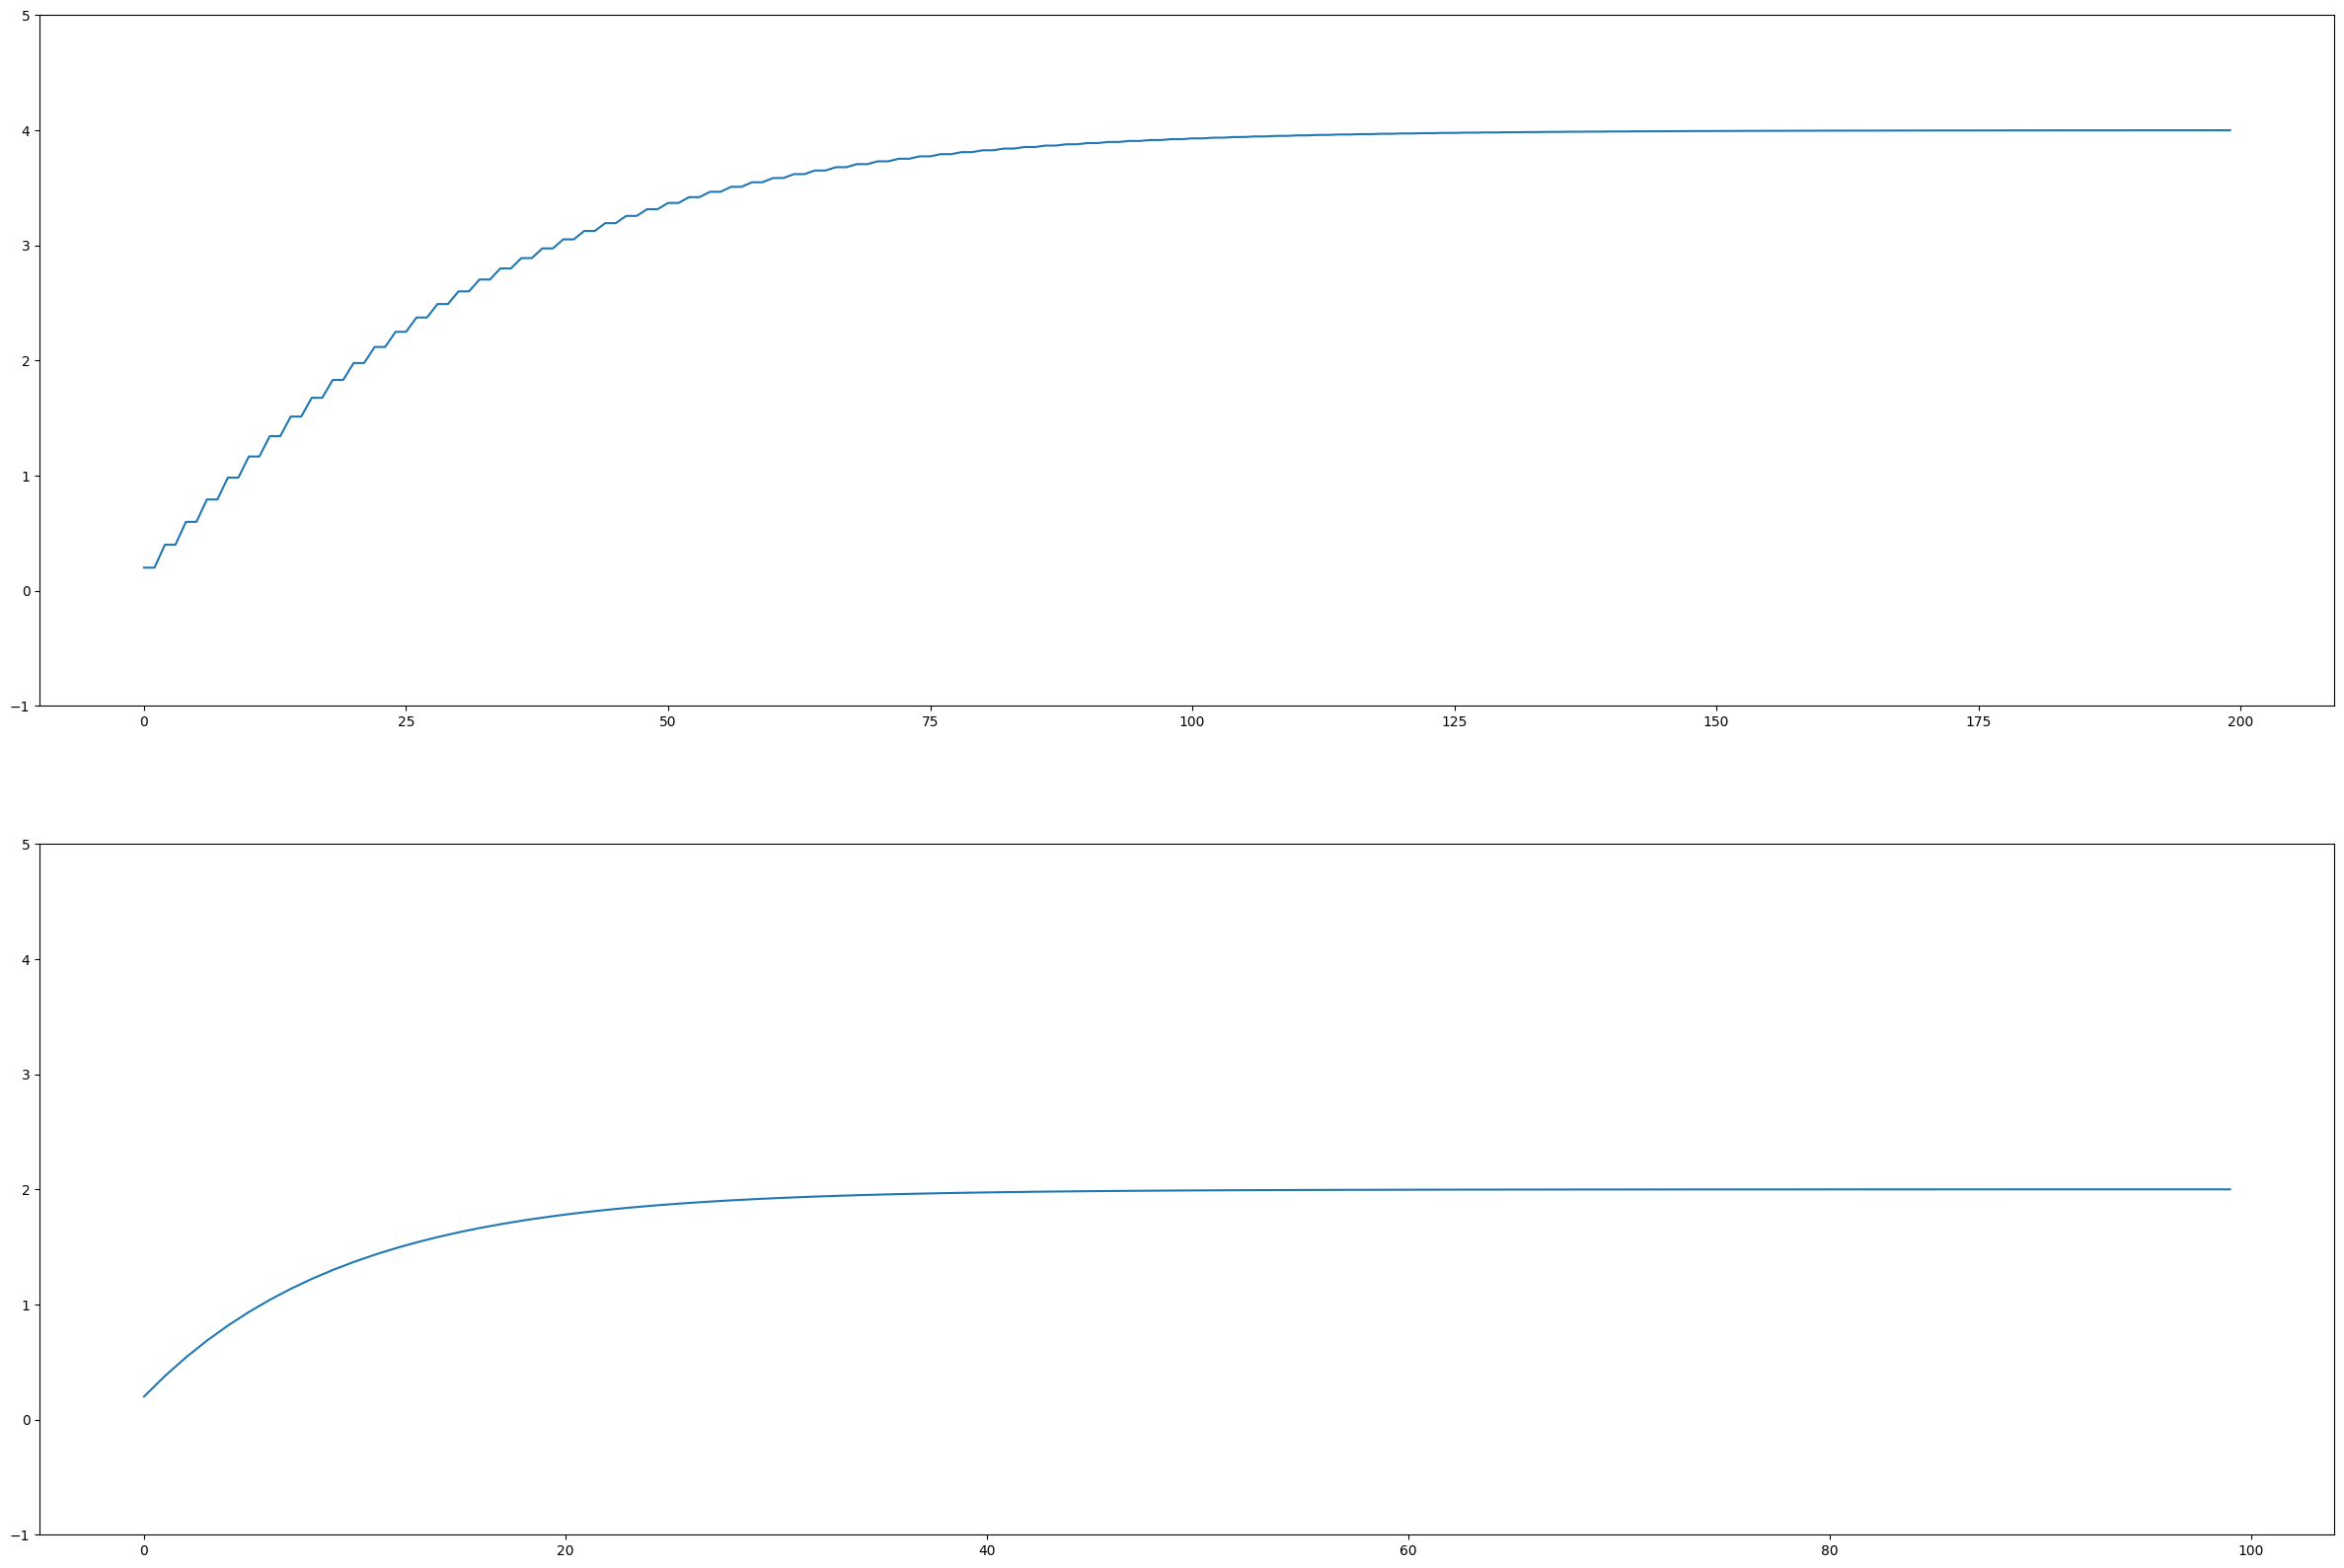

In [54]:
fig = plt.figure(figsize=(30,20))
ax: List[Axes] = fig.subplots(2)
for i in range(2):
    ax[i].set_ylim(-1,5)
    ax[i].plot(all_v[i])

In [49]:
print(v)

[3.999999989000006, 1.9999999995925928]


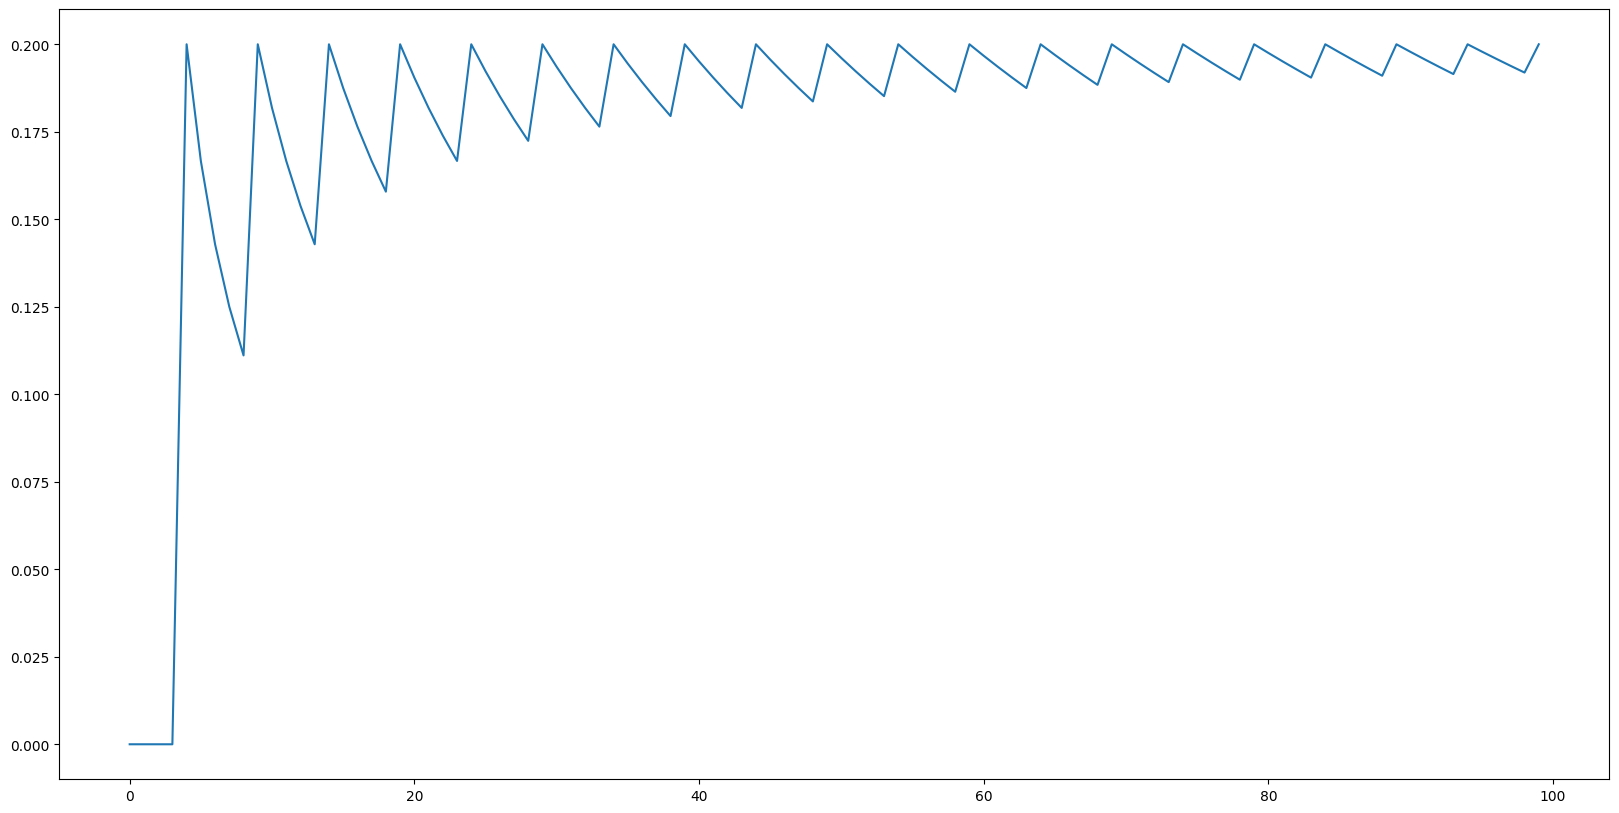

In [59]:
fig = plt.figure(figsize=(20,10))
ax = fig.subplots()
a = [0,0,0,0,1]
s = []
for x in range(1000):
    rm = 0 if len(s) == 0 else s[-1]
    s.append(rm+(a[x%5]-rm)/(x+1))

ax.plot(s[:100])